In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp

# Acoustic Waves

## with variable density/temperature

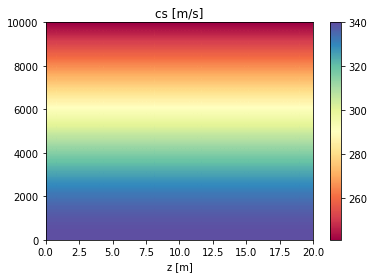

In [2]:
medium = 'atmosphere' # Choose 'atmosphere' or 'seawater'

time_step = 'RK2' # Choose a time-stepping scheme: 'FE' or 'RK2'


# constants
g = 9.81

#define grid
if medium=='seawater':
    nx,nz = 400,200
    Lx,Lz = 500000,5000
elif medium=='atmosphere':
    nx,nz = 400,200
    Lx,Lz = 20000,10000   
    
x0 = np.linspace(-Lx,Lx,nx)
z0 = np.linspace(0,Lz,nz)
xx,zz = np.meshgrid(x0,z0)
xx,zz = xx.T,zz.T



if medium=='atmosphere':

    #temp=np.linspace(20,10,nz)
    #gamma=7/5; # cp/cv
    #rd=287; # gas constant for dry air
    #zerodk = 273.15;
    #cs=(gamma*rd*(zerodk+temp))**0.5;
    
    c0=340; za=10000;
    cs =c0/np.sqrt(1+((z0)/za)**2)
    
    
elif medium=='seawater':
    
    temp = np.zeros_like(z0)
    salt = np.zeros_like(z0)

    #define speed of sound in seawater
    dtemp=1000.0; ds=700.0;
    sst=20.0; sbt=2.0;
    sss=35.0; sbs=34.8;

    bt=(sst-sbt)/(1-np.exp(-Lz/dtemp));
    at=sst-bt;

    bs=(sss-sbs)/(1-np.exp(-Lz/ds));
    asa=sss-bs;

    temp[0]=sst;
    salt[0]=sss;

    for k in range(1,nz):
        temp[k]=at+bt*np.exp(-z0[k]/dtemp);
        salt[k]=asa+bs*np.exp(-z0[k]/ds);

    a1=1448.96;
    a2=4.591;
    a3=-5.304e-02;
    a4=2.374e-04;
    a5=1.340;
    a6=1.630e-02;
    a7=1.675e-07;
    a8=-1.025e-02;
    a9=-7.139e-13;
    sref=35.0;
    
    cs = np.zeros_like(z0)
    for k in range(nz):
        cs[k]=a1+a2*temp[k]+a3*temp[k]**2+a4*temp[k]**3+a5*(salt[k]-sref)+a6*z0[k]+a7*z0[k]**2+a8*temp[k]*(salt[k]-sref)+a9*temp[k]*z0[k]**3;


##########

_,cs = np.meshgrid(x0,cs)
cs = cs.T

##########

if medium=='seawater':

    # Plot speed of sound
    plt.pcolormesh(xx/1e3,zz,cs,cmap=plt.cm.Spectral); plt.colorbar()
    plt.axis([0,Lx/1e3,Lz,0])
    plt.title('cs [m/s]'); plt.xlabel('x [km]'); plt.xlabel('z [m]')

elif medium=='atmosphere':

    # Plot speed of sound
    plt.pcolormesh(xx/1e3,zz,cs,cmap=plt.cm.Spectral); plt.colorbar()
    plt.axis([0,Lx/1e3,0,Lz])
    plt.title('cs [m/s]'); plt.xlabel('x [km]'); plt.xlabel('z [m]')
    
    


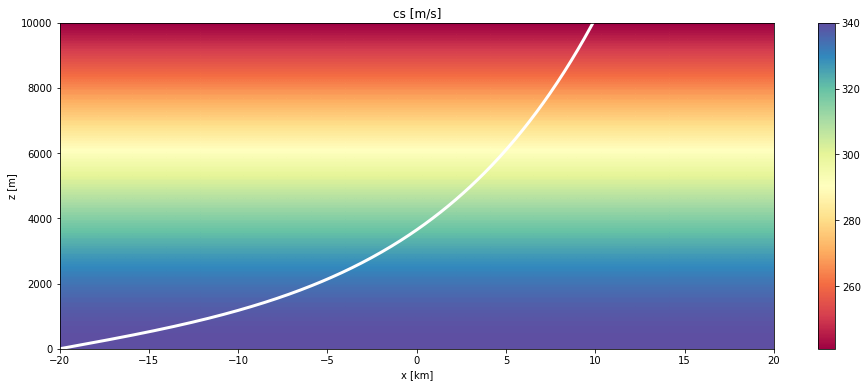

In [8]:
####
# define time
Lt = 3*np.max([Lx,Lz])/cs.min() # total integration time
dt = Lt/1000 # time-step

times = np.arange(0,Lt,dt)
nt = len(times)

####
# Plot topography

plt.figure(figsize=(16.,6.))
plt.pcolormesh(xx/1e3,zz,cs,cmap=plt.cm.Spectral); plt.colorbar()
plt.title('cs [m/s]'); plt.xlabel('x [km]'); plt.ylabel('z [m]')

###
# Interpolate topography at a given point
csij =  interp.RectBivariateSpline(x0,z0,cs)

#define gradient of sqrt of topography
dx=x0[1]-x0[0]
dz=z0[1]-z0[0]
dcsdx,dcsdz = np.gradient(cs,dx,dz)

# Interpolate gradient of topography at a given point
dcsdxij = interp.RectBivariateSpline(x0,z0,dcsdx)
dcsdzij = interp.RectBivariateSpline(x0,z0,dcsdz)

###

def advance(k_x,k_z,x,z,dt):
    ''' Compute dk_x,dk_z,dx,dz '''
    
    dsigsx = np.sqrt((k_x**2 + k_z**2)) * dcsdxij(x,z)
    dsigsz = np.sqrt((k_x**2 + k_z**2)) * dcsdzij(x,z)

    dk_x = - dsigsx * dt
    dk_z = - dsigsz * dt
    
    cg_x = k_x * csij(x,z) / np.sqrt(k_x**2 + k_z**2)
    cg_z = k_z * csij(x,z) / np.sqrt(k_x**2 + k_z**2)  

    dx = cg_x * dt
    dz = cg_z * dt
    
    return dk_x,dk_z,dx,dz
    
####

x = np.zeros(nt+1) * np.nan
z = np.zeros(nt+1) * np.nan
k_x = np.zeros(nt+1) * np.nan
k_z = np.zeros(nt+1) * np.nan

# initial conditions
if medium == 'seawater':
    x[0] = 0
    z[0] = 1000
    k_x[0] = 1.
    k_z[0] = 0.
elif medium == 'atmosphere':
    x[0] = x0[0]
    z[0] = 0
    k_x[0] = 1.
    k_z[0] = 0.1


for i,time in enumerate(times):

    if x0.min()<=x[i]<x0.max() and z0.min()<=z[i]<z0.max():

        if time_step == 'FE':
            [dk_,dk_z,dx,dz] = advance(k_x[i],k_z[i],x[i],z[i],dt)
            k_x[i+1],k_z[i+1],x[i+1],z[i+1] = k_x[i]+dk_x,k_z[i]+dk_z,x[i]+dx,z[i]+dz

        elif time_step == 'RK2':     
            [dk_x,dk_z,dx,dz] = advance(k_x[i],k_z[i],x[i],z[i],dt/2)
            [dk_x,dk_z,dx,dz] = advance(k_x[i]+dk_x,k_z[i]+dk_z,x[i]+dx,z[i]+dz,dt)
            k_x[i+1],k_z[i+1],x[i+1],z[i+1] = k_x[i]+dk_x,k_z[i]+dk_z,x[i]+dx,z[i]+dz
    else:

        break

#######


plt.plot(x/1e3,z,'-w',linewidth=3.); 
if medium == 'seawater': plt.axis([0,Lx/1e3,Lz,0])
elif medium == 'atmosphere': plt.axis([x0[0]/1e3,Lx/1e3,0,Lz])  


# Surface gravity waves

### With variable topography

Text(0.5, 0, 'y [km]')

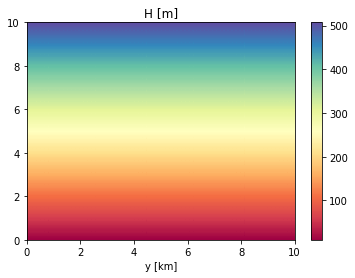

In [9]:
time_step = 'RK2' # Choose a time-stepping scheme: 'FE' or 'RK2'

g = 9.81

#define grid
nx,ny = 400,200
Lx,Ly = 10000,10000

x0 = np.linspace(-Lx,Lx,nx)
y0 = np.linspace(0,Ly,ny)
xx,yy = np.meshgrid(x0,y0)
xx,yy = xx.T,yy.T



#define topogaphy
Hmax = 500.
topography = 'slope'

if topography == 'island':
    H = Hmax * (1 - 1.1 * np.exp(-((xx-Lx/2)**2+(yy-Ly/2)**2)/(100*Lx))) # Island
elif topography == 'slope':
    H = np.abs(10 + yy/Ly * 500) # Slope
elif topography == 'ridge':
    H = Hmax * (np.abs(yy - Ly/2)/Ly) # Ridge

# ensure Positive topography:
H[H<0.] = 0.

# Plot topography
plt.pcolormesh(xx/1e3,yy/1e3,H,cmap=plt.cm.Spectral); plt.colorbar()
plt.axis([0,Lx/1e3,0,Ly/1e3])
plt.title('H [m]'); plt.xlabel('x [km]'); plt.xlabel('y [km]')


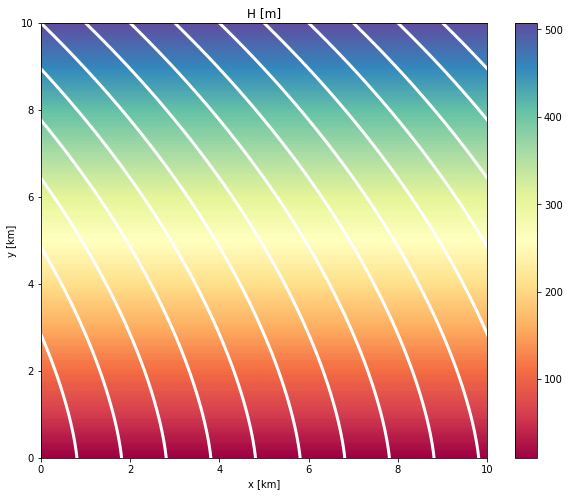

In [10]:
####
# define time
Lt = 2*np.max([Lx,Ly])/np.sqrt(g*Hmax) # total integration time
dt = Lt/100 # time-step

times = np.arange(0,Lt,dt)
nt = len(times)

####
# Plot topography

plt.figure(figsize=(10.,8.))
plt.pcolormesh(xx/1e3,yy/1e3,H,cmap=plt.cm.Spectral); plt.colorbar()
plt.title('H [m]'); plt.xlabel('x [km]'); plt.ylabel('y [km]')

###
# Interpolate topography at a given point
Hij =  interp.RectBivariateSpline(x0,y0,H)

#define gradient of sqrt of topography
dx=x0[1]-x0[0]
dy=y0[1]-y0[0]
dHdx,dHdy = np.gradient(np.sqrt(H),dx,dy)

# Interpolate gradient of topography at a given point
dHdxij = interp.RectBivariateSpline(x0,y0,dHdx)
dHdyij = interp.RectBivariateSpline(x0,y0,dHdy)

###

def advance(k_x,k_y,x,y,dt):
    ''' Compute dk_x,dk_y,dx,dy '''
    
    dsigsx = np.sqrt(g * (k_x**2 + k_y**2)) * dHdxij(x,y)
    dsigsy = np.sqrt(g * (k_x**2 + k_y**2)) * dHdyij(x,y)

    dk_x = - dsigsx * dt
    dk_y = - dsigsy * dt
    
    cg_x = k_x * np.sqrt(g * np.max([Hij(x,y),0.])) / np.sqrt(k_x**2 + k_y**2)
    cg_y = k_y * np.sqrt(g * np.max([Hij(x,y),0.])) / np.sqrt(k_x**2 + k_y**2)  

    dx = cg_x * dt
    dy = cg_y * dt
    
    return dk_x,dk_y,dx,dy
    
####



for ray,xinit in enumerate(np.arange(x0[0],x0[-1],Lx/10)):
#for ray,yinit in enumerate(np.arange(y0[0],y0[-1],Ly/10)):
    
    x = np.zeros(nt+1) * np.nan
    y = np.zeros(nt+1) * np.nan
    k_x = np.zeros(nt+1) * np.nan
    k_y = np.zeros(nt+1) * np.nan

    # initial conditions
    x[0] = xinit
    y[0] = Ly-1
    k_x[0] = 1.
    k_y[0] = -1.

    for i,time in enumerate(times):

        if x0.min()<=x[i]<x0.max() and y0.min()<=y[i]<y0.max():

            if time_step == 'FE':
                [dk_x,dk_y,dx,dy] = advance(k_x[i],k_y[i],x[i],y[i],dt)
                k_x[i+1],k_y[i+1],x[i+1],y[i+1] = k_x[i]+dk_x,k_y[i]+dk_y,x[i]+dx,y[i]+dy

            elif time_step == 'RK2':     
                [dk_x,dk_y,dx,dy] = advance(k_x[i],k_y[i],x[i],y[i],dt/2)
                [dk_x,dk_y,dx,dy] = advance(k_x[i]+dk_x,k_y[i]+dk_y,x[i]+dx,y[i]+dy,dt)
                k_x[i+1],k_y[i+1],x[i+1],y[i+1] = k_x[i]+dk_x,k_y[i]+dk_y,x[i]+dx,y[i]+dy
        else:

            break

    #######


    plt.plot(x/1e3,y/1e3,'-w',linewidth=3.); plt.axis([0,Lx/1e3,0,Ly/1e3])

